# Xarray-spatial User Guide:
## Zonal
-----

[Generate terrain](#Generate-Terrain-Data)
[Zonal Statistics](#Zonal-Statistics)

-----------


### Getting Started:
#### Prepare your packages:
We'll need the basic Numpy and Pandas, as well as datashader, a data rasterization  
and rendering package highly compatible with Xarray-spatial that will help us  
quickly visualize our raster data.  
Along with the base package, we'll import several nested functions (shade, stack...) including  
some color maps, which will all come in handy soon.  
Finally, we'll import Xarray-spatial.

In [4]:
import numpy as np
import pandas as pd

import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation
from datashader.colors import Set1

import xrspatial

/Users/ls/anaconda3/envs/xrs/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Generate Terrain Data

The geo-related functions of Xarray-spatial work with rasters, or array data that's been "aggregated" into the grided cells pattern of a raster image. Datashader's Canvas object provides a quick-and-easy frame to use when starting out a new raster. We'll use that with the generate terrain function to get a simulated terrain to experiment on with other Xarray-functions. 
Datashader's shade gives us a quick visualization.

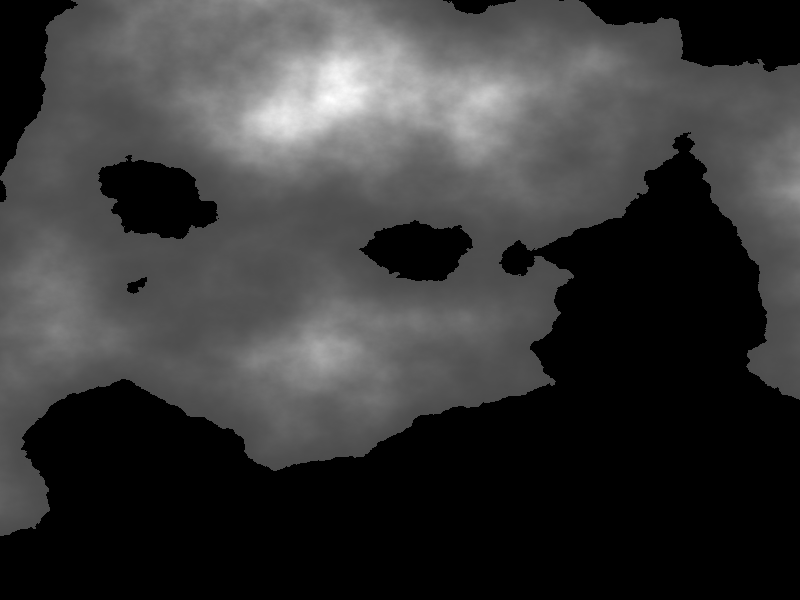

In [5]:
from xrspatial import generate_terrain

W = 800
H = 600

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20e6, 20e6), y_range=(-20e6, 20e6))
terrain = generate_terrain(canvas=cvs)

shade(terrain, cmap=['black', 'white'], how='linear')

The grayscaled image above shows the elevation, scaled linearly in brightness from black to white (with black areas indicating low elevation and white ones high elevation). We could make it look more realistic by using some more colorful shading. Let's bring in datashader's Elevation colormap we imported above.

/Users/ls/anaconda3/envs/xrs/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


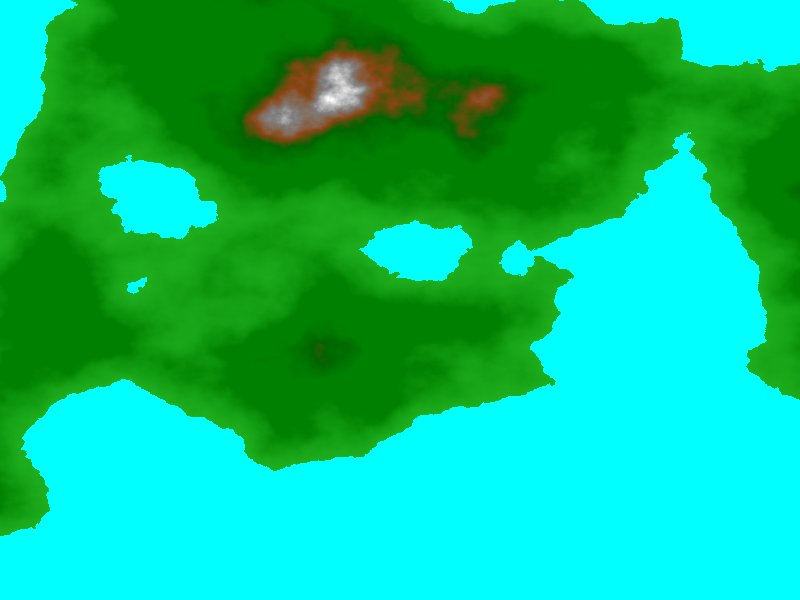

In [6]:
shade(terrain, cmap=Elevation, how='linear')

This gives more "natural" colors, with blue for "sea" and green / brown for mountain or mountaintop. As we'll see going forward, even with the same data, applying the right shading can make a huge difference in how much of the data's information is accessible.

## Zonal Statistics

Xarray-spatial's zonal statistics function lets us calculate summary statistics for specific areas or *zones* within a raster aggregate (array data "aggregated" into the gridded cells pattern of a raster). A values aggregate is partitioned into Zones by creating a corresponding *zones* integer aggregate of the same shape, where the integer value at each cell is the zone_id of the corresponding cell in the values aggregate. Zonal statistics calculates summary statistics of the values, by zone, and returns the results in a Pandas dataframe.

#### Example use case:
Imagine the following scenario:
- You do a 6-day hike in an area represented by a terrain elevation raster.
- Each day's travel path is defined by a line segement.
- You want to calculate the max and min elevation for each da y's path.
To do this, we'll first need to set out our hypothetical elevation terrain. Using  
datashader's canvas and generate terrain gets us started.
Next, we'll apply hillshade with some gradient shading to get more definition in the visualiztion.
Finally, we can set up the *zones* aggregate we'll use for the statistics calculations:
   - We set up a Pandas dataframe with start and end points for all days' travel paths.
   - We use the canvas from earlier to set that into line represeantations in a raster.
   - We shade (colormap) it and stack the lines and the terrain we played with earlier  
   for a complete picture of the terrain and travel paths.

/Users/ls/anaconda3/envs/xrs/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


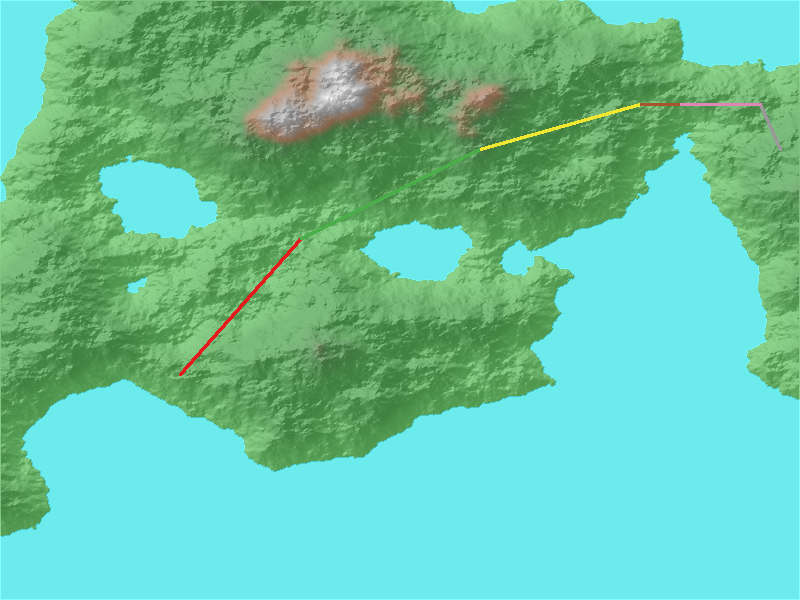

In [8]:
from xrspatial import hillshade

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20, 20), y_range=(-20, 20))

terrain = generate_terrain(canvas=cvs)
terrain_shaded = shade(terrain, cmap=Elevation, alpha=128, how='linear')

illuminated = hillshade(terrain)
illuminated_shaded = shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear')

zone_df = pd.DataFrame({
   'x': [-11, -5, 4, 12, 14, 18, 19],
   'y': [-5, 4, 10, 13, 13, 13, 10],
   'trail_segement_id': [11, 12, 13, 14, 15, 16, 17]
})

zones_agg = cvs.line(zone_df, 'x', 'y', ds.sum('trail_segement_id'))
zones_shaded = dynspread(shade(zones_agg, cmap=Set1), max_px=5)

stack(illuminated_shaded, terrain_shaded, zones_shaded)

Now we're ready to apply the zonal statistics function.
As one final step, we'll just get rid of those pesky nan's in the *integers* zones aggregate, and now we can apply the zones to the elevation terrain and get stats.

In [10]:
from xrspatial import zonal_stats
zones_agg.values = np.nan_to_num(zones_agg.values, copy=False).astype(np.int)
zonal_stats(zones_agg, terrain)

<ipython-input-10-cfdab43d6b76>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  zones_agg.values = np.nan_to_num(zones_agg.values, copy=False).astype(np.int)


,mean,max,min,std,var,count
11,1321.919879,1428.384240,1228.065037,53.409131,2852.535316,136.0
12,1489.600166,2399.556289,1220.694206,310.177594,96210.140061,180.0
13,1711.632114,2430.430303,1368.922124,278.369664,77489.669636,160.0
14,1355.661087,1368.952389,1346.856316,6.249734,39.059170,40.0
15,1381.950485,1443.856734,1319.891060,38.918956,1514.685125,80.0
16,1486.314866,1709.222348,1367.673562,120.950684,14629.068060,45.0


As you can see, we get the max and min for each zone, along with a default set of other statistic values.

##### Calculate custom stats for each zone:
We can also set our own custom set of stats calculations to perform on the zones by passing  
a custom_stats dict as the third argument (stat_funcs, if you want to use the keyword) in zonal_stats, and we get a returned dataframe with only our custom stats.

In [11]:
custom_stats = dict(elevation_change=lambda zone: zone.max() - zone.min(),
                    elevation_min=np.min,
                    elevation_max=np.max)

zonal_stats(zones_agg, terrain, custom_stats)

/Users/ls/anaconda3/envs/xrs/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,elevation_change,elevation_min,elevation_max
11,200.319203,1228.065037,1428.384240
12,1178.862083,1220.694206,2399.556289
13,1061.508179,1368.922124,2430.430303
14,22.096073,1346.856316,1368.952389
15,123.965674,1319.891060,1443.856734
16,341.548786,1367.673562,1709.222348


#### A final note:
In this relatively simple example the zones are defined by line segments, but zones can be any spatial pattern (or any set of cells in the values raster you wish to put into a *zone* to get statistics for), as long as you can aggregate it (using datashader) into cells in a raster the same shape as the original values raster.